<a href="https://colab.research.google.com/github/romanowiczadam/ml_course/blob/master/08_backward_elimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
np.set_printoptions(precision = 4, suppress = True)
sns.set(font_scale=1.3)
sklearn.__version__

'0.22.2.post1'

In [124]:
df_raw = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ml-course/insurance.csv')
df_raw

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [125]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# sprawdzenie czy w danych nie ma duplikatów
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [126]:
# sprawdzamy gdzie kolumna charges jest taka sama
df[df['charges'] == 1639.5631]  

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [127]:
# usuniecie duplikatow
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [128]:
# zmiana typu danych z object
cat_col = [c for c in df.columns if df[c].dtype == 'O']
cat_col

['sex', 'smoker', 'region']

In [129]:

for c in cat_col:
  df[c] =df[c].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 56.5 KB


In [130]:
  df.describe(include=['category']).T

,count,unique,top,freq
sex,1337,2,male,675
smoker,1337,2,no,1063
region,1337,4,southeast,364


In [131]:
# sprawdzenie czy nie ma brakó danych
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [132]:
# sprawdzenie rozkładu dla płci dzięki value counts
df['sex'].value_counts()

male      675
female    662
Name: sex, dtype: int64

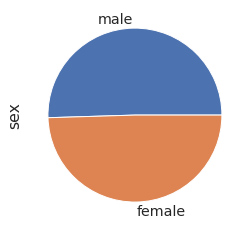

In [133]:
df['sex'].value_counts().plot(kind = 'pie')

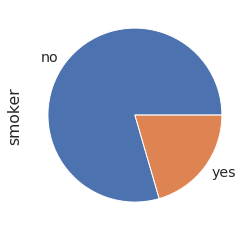

In [134]:
df['smoker'].value_counts().plot(kind = 'pie')

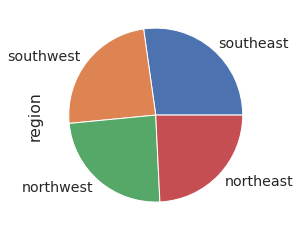

In [135]:
df['region'].value_counts().plot(kind = 'pie')

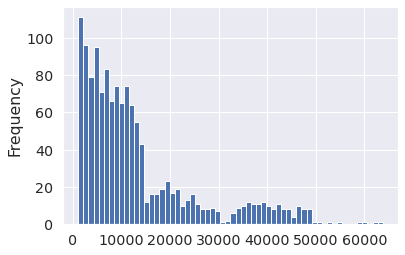

In [136]:
df['charges'].plot(kind = 'hist', bins = 60)

In [137]:
import plotly.express as px

px.histogram(data_frame = df, x = 'charges', nbins = 50, facet_col = 'smoker', facet_row = 'sex')

In [138]:
# przygotowanie danych do modelu
df_dummies = pd.get_dummies(df, drop_first = True)
df_dummies

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


In [139]:
# badanie korelacji poszczegolnych zmiennych
corr = df_dummies.corr()
corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109344,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.046397,0.003746,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.058044,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046397,0.017848,0.058044,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003746,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006211,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000


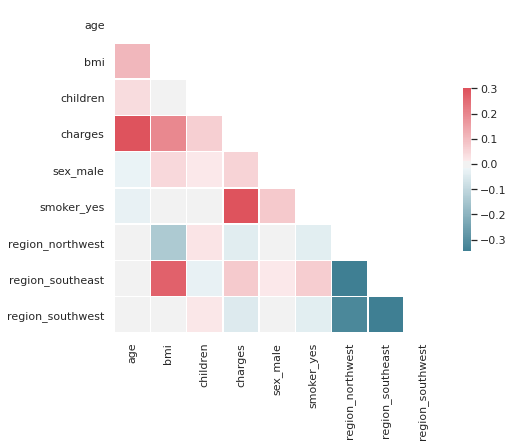

In [140]:
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [141]:
corr['charges'].sort_values(ascending = False)

charges             1.000000
smoker_yes          0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex_male            0.058044
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64

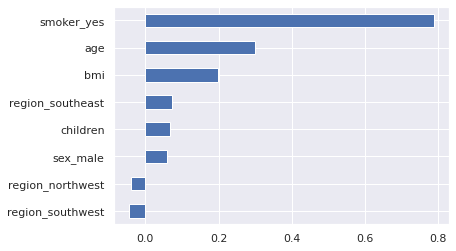

In [142]:
sns.set()
corr['charges'].sort_values(ascending = True)[:-1].plot(kind='barh')

In [143]:
data = df_dummies.copy()
target = data.pop('charges')
data


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,1,0,1,0,0
1334,18,31.920,0,0,0,0,0,0
1335,18,36.850,0,0,0,0,1,0
1336,21,25.800,0,0,0,0,0,1


In [144]:
target

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1337, dtype: float64

In [145]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

print(f'x train shape:{x_train.shape}')
print(f'y train shape:{y_train.shape}')
print(f'x test shape:{x_test.shape}')
print(f'y test shape:{y_test.shape}')

x train shape:(1069, 8)
y train shape:(1069,)
x test shape:(268, 8)
y test shape:(268,)


In [146]:
# import klasy oraz utworzenie jej instancji
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
# dopasowanie modelu liniowego do danych
regressor.fit(data, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [147]:
print(f'R2 score:{regressor.score(x_test, y_test)}')

R2 score:0.8141413310529316


In [148]:
y_pred = regressor.predict(x_test) 
y_pred[:10]

array([ 8153.6489,  5133.6261, 14577.2971, 32483.0477,  8831.8608,
       13155.0835, 31206.3092,   995.9664, 10634.7586, 11323.7548])

In [149]:
y_true = y_test.copy()
predictions = pd.DataFrame(data = {'y_test' : y_test, 'y_pred' : y_pred})
predictions

,y_test,y_pred
900,8688.85885,8153.648881
1064,5708.86700,5133.626073
1256,11436.73815,14577.297051
298,38746.35510,32483.047725
237,4463.20510,8831.860780
...,...,...
534,13831.11520,17064.485225
542,13887.20400,15519.135573
760,3925.75820,6393.182478
1284,47403.88000,39273.458418


In [150]:
predictions['error'] = predictions['y_test'] - predictions['y_pred']
predictions

,y_test,y_pred,error
900,8688.85885,8153.648881,535.209969
1064,5708.86700,5133.626073,575.240927
1256,11436.73815,14577.297051,-3140.558901
298,38746.35510,32483.047725,6263.307375
237,4463.20510,8831.860780,-4368.655680
...,...,...,...
534,13831.11520,17064.485225,-3233.370025
542,13887.20400,15519.135573,-1631.931573
760,3925.75820,6393.182478,-2467.424278
1284,47403.88000,39273.458418,8130.421582


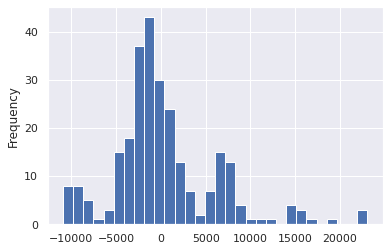

In [151]:
predictions.error.plot(kind= 'hist', bins = 30)

In [152]:
# mean absolute error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE wynosi: {mae:.2f}')

MAE wynosi: 4117.58


In [153]:
regressor.intercept_

-11936.557507206637

In [154]:
regressor.coef_

array([  256.7646,   339.2504,   474.8205,  -129.4815, 23847.3288,
        -349.2265, -1035.2656,  -960.0814])

In [155]:
data.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

Eliminacja wsteczna

In [163]:
import statsmodels.api as sm

X_train_ols = x_train.copy()
# przeształcenie na ndarray
X_train_ols = X_train_ols.values
# dodanie jedynek
X_train_ols = sm.add_constant(X_train_ols)
X_train_ols

array([[ 1.   , 23.   , 24.51 , ...,  0.   ,  0.   ,  0.   ],
       [ 1.   , 21.   , 25.745, ...,  0.   ,  0.   ,  0.   ],
       [ 1.   , 52.   , 37.525, ...,  1.   ,  0.   ,  0.   ],
       ...,
       [ 1.   , 20.   , 22.   , ...,  0.   ,  0.   ,  1.   ],
       [ 1.   , 38.   , 28.   , ...,  0.   ,  0.   ,  1.   ],
       [ 1.   , 35.   , 35.86 , ...,  0.   ,  1.   ,  0.   ]])

In [157]:
# OLS jest regresją liniową w bibliotece statsmodels
ols = sm.OLS(endog = y_train, exog= X_train_ols).fit()
predictors = ['const'] + list(x_train.columns)
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     358.1
Date:                Sun, 12 Jul 2020   Prob (F-statistic):          4.94e-295
Time:                        12:30:54   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1060   BIC:                         2.172e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.109e+04   1114.260  

In [164]:
x_selected = X_train_ols[:, [0, 1, 2, 3, 5, 6, 7, 8]]


ols = sm.OLS(endog=y_train, exog=x_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     409.6
Date:                Sun, 12 Jul 2020   Prob (F-statistic):          2.44e-296
Time:                        12:37:05   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1061   BIC:                         2.172e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.113e+04   1102.801  

In [168]:
x_selected = X_train_ols[:, [0, 1, 2, 3, 5, 7, 8]]


ols = sm.OLS(endog=y_train, exog=x_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     478.0
Date:                Sun, 12 Jul 2020   Prob (F-statistic):          1.40e-297
Time:                        12:47:52   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1062   BIC:                         2.171e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.132e+04   1072.467  

In [169]:
x_selected = X_train_ols[:, [0, 1, 2, 3, 5, 7]]
predictors.remove('region_southwest')

ols = sm.OLS(endog=y_train, exog=x_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     573.4
Date:                Sun, 12 Jul 2020   Prob (F-statistic):          8.97e-299
Time:                        12:48:48   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1063   BIC:                         2.171e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.139e+04   1069.862  

In [170]:
x_selected = X_train_ols[:, [0, 1, 2, 3, 5]]
predictors.remove('region_southeast')

ols = sm.OLS(endog=y_train, exog=x_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     716.3
Date:                Sun, 12 Jul 2020   Prob (F-statistic):          5.56e-300
Time:                        12:49:20   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.167e+04
Df Residuals:                    1064   BIC:                         2.170e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.126e+04   1062.104    -10.599      0.0